### Just a tweak to use sublime shortcuts

In [23]:
%%javascript
require(["codemirror/keymap/sublime", "notebook/js/cell", "base/js/namespace"],
    function(sublime_keymap, cell, IPython) {
        cell.Cell.options_default.cm_config.keyMap = 'sublime';
        var cells = IPython.notebook.get_cells();
        for(var cl=0; cl< cells.length ; cl++){
            cells[cl].code_mirror.setOption('keyMap', 'sublime');
        }
    }
);

<IPython.core.display.Javascript object>

In [2]:
# Install tensorflow provided datasets
!pip install -U tensorflow_datasets

In [3]:
# Necessary imports
import tensorflow as tf

# Import TensorFlow Datasets
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

# Helper libraries
import math
import numpy as np
import matplotlib.pyplot as plt

# Logging
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

### Fashion MNIST dataset
The Fashion MNIST dataset comes as a dictionary, with an already performed train and test dataset split. Metadata provide information about the dataset.

In [4]:
# Load dataset and metadata
dataset, metadata = tfds.load('fashion_mnist', as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset['train'], dataset['test']
print(type(train_dataset))

<class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>


In [5]:
# Extract label from metadata
class_names = metadata.features['label'].names
print("Class names: {}".format(class_names))

Class names: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [6]:
# Read information on train and test dataset
num_train_examples = metadata.splits['train'].num_examples
num_test_examples = metadata.splits['test'].num_examples
print("Number of training examples: {}".format(num_train_examples))
print("Number of test examples:     {}".format(num_test_examples))

Number of training examples: 60000
Number of test examples:     10000


###  Preprocessing

In [7]:
from local import preprocessing as pr
from local import visualization as vs

In [8]:
# Plot of a single image
# Take a single image, and remove the color dimension by reshaping
for image, label in test_dataset.take(1):
    break
print('Image shape before color dimension removal:', np.shape(image))
image = image.numpy().reshape((28,28))
print('Image shape after color dimension removal: ', np.shape(image))

Image shape before color dimension removal: (28, 28, 1)
Image shape after color dimension removal:  (28, 28)


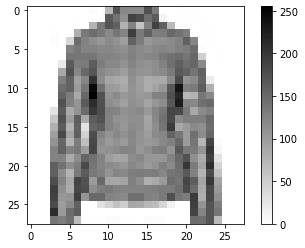

In [9]:
# Plot the image - voila a piece of fashion clothing
plt.figure()
plt.imshow(image, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

In [10]:
# The map function applies the normalize function to each element in the train and test datasets
# The normalize function converts the integer value in [0,255] to a float value in [0,1]
train_dataset =  train_dataset.map(pr.normalize)
test_dataset  =  test_dataset.map(pr.normalize)
print(type(train_dataset))
print(train_dataset)

<class 'tensorflow.python.data.ops.dataset_ops.MapDataset'>
<MapDataset shapes: ((28, 28, 1), ()), types: (tf.float32, tf.int64)>


In [11]:
# The first time you use the dataset, the images will be loaded from disk
# Caching will keep them in memory, making training faster
train_dataset =  train_dataset.cache()
test_dataset  =  test_dataset.cache()
print(type(train_dataset))
print(train_dataset)

<class 'tensorflow.python.data.ops.dataset_ops.CacheDataset'>
<CacheDataset shapes: ((28, 28, 1), ()), types: (tf.float32, tf.int64)>


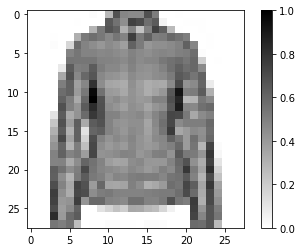

In [12]:
# Take a single image, and remove the color dimension by reshaping
for image, label in test_dataset.take(1):
    break
image = image.numpy().reshape((28,28))

# Plot the image - voila a piece of fashion clothing
plt.figure()
plt.imshow(image, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

### Building the model

Model consists of a neural network with three layers. <ul>
<li>Layer1 transforms the images from a 2d-array of 28×28 pixels to a 1d-array of 784 pixels (28×28). 
<li>Layer2 takes input from all 784 nodes in the previous layer, weighting that input according to hidden parameters which will be learned during training, and outputs a set of 128 single values to the next layer. 
<li>Layer3 takes input from the 128 nodes in the previous layer and outputs a set of 10 values in the range [0,1] representing the probability that the image belongs to a specific class. 
</ul>

In [13]:
# Model definition
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28, 1)),         #Layer1
    tf.keras.layers.Dense(128, activation=tf.nn.relu),        #Layer2
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)       #Layer3
])

Before the model is ready for training, it needs a few more settings. These are added during the model's compile step: <ul> 
<li> Loss function: an algorithm for measuring how far the model's outputs are from the desired output. The goal of training is this measures loss.
<li> Optimizer: an algorithm for adjusting the inner parameters of the model in order to minimize loss.
<li> Metrics: user defined criteria for classification evaluation.
</ul>

In [14]:
# Compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [15]:
# Training the model
BATCH_SIZE = 32
train_dataset = train_dataset.cache().repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
test_dataset = test_dataset.cache().batch(BATCH_SIZE)

In [16]:
train_history = model.fit(train_dataset, epochs=5, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))

Epoch 1/5
1875/1875 [==============================] - 8s 3ms/step - loss: 0.6310 - accuracy: 0.7797
Epoch 2/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3868 - accuracy: 0.8596
Epoch 3/5
1875/1875 [==============================] - 5s 2ms/step - loss: 0.3464 - accuracy: 0.8736
Epoch 4/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3159 - accuracy: 0.8852
Epoch 5/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2956 - accuracy: 0.8914


In [17]:
# Just showing how to access accuracy and loss information over epochs
print(train_history.history)

{'loss': [0.49887728691101074, 0.37061476707458496, 0.33576613664627075, 0.31056690216064453, 0.2930757701396942], 'accuracy': [0.8222500085830688, 0.8654166460037231, 0.8766833543777466, 0.8859166502952576, 0.8925166726112366]}


### Model evaluation

In [18]:
# Model performance on the test dataset
test_loss, test_accuracy = model.evaluate(test_dataset, steps=math.ceil(num_test_examples/32))
print('Accuracy on test dataset:', test_accuracy)

313/313 [==============================] - 1s 4ms/step - loss: 0.3697 - accuracy: 0.8702
Accuracy on test dataset: 0.870199978351593
